**Hunter Mitchell**

**October 18th, 2020**

**Problem Statement:**

The objective is to construct a model which accurately predicts whether a house will sell at above or below \$200,000. This is a binary classification problem and will be approached using Machine Learning and Data Science fundamentals.

# EDA

Start by importing necessary libraries to explore the data

In [1]:
import pandas as pd
import numpy as np

SEED = 42 # for reproducability

import warnings
warnings.filterwarnings('ignore') # ignoring any warnings

Loading in the training data downloaded from [here](https://www.kaggle.com/c/home-data-for-ml-course/data)

In [2]:
TRAIN_PATH = '/content/train.csv'

train = pd.read_csv(TRAIN_PATH)

In [3]:
train.shape

(1460, 81)

It looks like there are 1,460 instances with 81 total columns. I'm going to take a look at a few rows to understand the data better.

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


It looks like there's a lot of categorical data. Let's see how many categorical columns and numerical columns there are.

In [5]:
cat_columns = list(train.select_dtypes(include='object').columns)
print(len(cat_columns), 'Categorical columns')
print(train.shape[1] - len(train.select_dtypes(include='object').columns), 'Numerical columns')

43 Categorical columns
38 Numerical columns


There are a bit more categorical columns than numerical. Before the data can be fed into the model, all the categorical columns will need to be encoded.

Now I'm going to look at the target variable, 'SalePrice'.

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

And plot the distribution

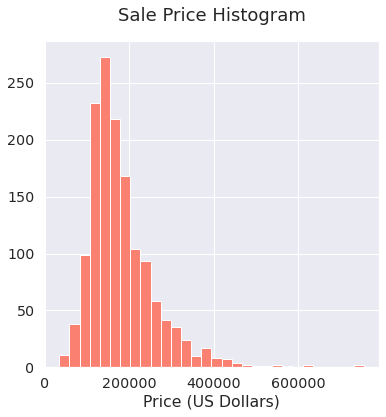

In [69]:
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(6,6))
plt.hist(train['SalePrice'], bins=30, color='salmon')
plt.title('Sale Price Histogram', fontdict={'fontsize': 18}, pad = 20)
plt.xlabel('Price (US Dollars)')
plt.show()

The target variable seems to be normally distributed but perhaps skewed right a bit. It also looks like there are more instances that are under $200,000 than over. I'll plot this as a pie chart as well.

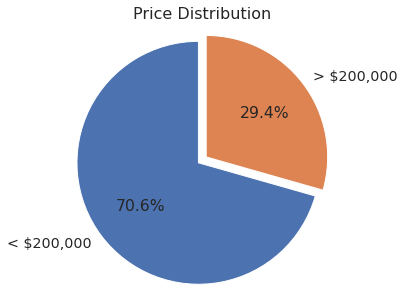

In [70]:
# Pie Chart

plt.figure(figsize=(5,5))
labels = ['< $200,000', '> $200,000']
sizes = [len(train[train['SalePrice'] < 200000]), 
         len(train[train['SalePrice'] > 200000])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=[0,0.08], startangle=90)
plt.title('Price Distribution', fontdict={'fontsize': 16})
plt.axis('equal')
plt.show()

It turns out just over 70% of the houses are less than \$200,000. 

There could also be houses that are exactly \$200,000.

In [24]:
print('There are', len(train[train['SalePrice'] == 200000]), 'Houses that are exactly $200,000')

There are 8 Houses that are exactly $200,000


The instructions state to only classify houses as above or below $200,000, so I am going to drop these rows when I clean the data.

Since this is typically a regression problem, we can get some insight into what features will probably be most useful by looking at how they correlate to sales price.

In [25]:
corr_matrix = train.corr()
corr_matrix['SalePrice'].sort_values(ascending=False).head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

For the numerical features, it looks like 'OverallQual' and 'GrLivArea' will most likely impact the classifications the most, since they correlate highest to sale price

# Prepare Data

First, drop instances of exactly $200,000 as discussed already.

In [26]:
train = train[train['SalePrice'] != 200000]

Now create target column containing a 1 if the price is greater than $200,000, and a 0 if it is less.

In [27]:
target = train['SalePrice'].apply(lambda x: 1 if x > 200000 else 0)

The features are every column other than the Id and Price

In [28]:
features = train.drop(columns=['SalePrice','Id'])

Before I do anything else, I am going to create a test set to verify the model's performance on data it has never seen before.

In [29]:
from sklearn.model_selection import train_test_split

In [74]:
x_train,x_test,y_train,y_test = train_test_split(features,
                                                 target,
                                                 test_size=0.2,
                                                 random_state=SEED)

Now I am going to check for null values in the data. If a column has a lot of missing data, I am going to drop the whole column, as it will not carry much information.

In [75]:
x_train[x_train.columns[x_train.isna().any()].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161 entries, 1268 to 1131
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   953 non-null    float64
 1   Alley         71 non-null     object 
 2   MasVnrType    1155 non-null   object 
 3   MasVnrArea    1155 non-null   float64
 4   BsmtQual      1129 non-null   object 
 5   BsmtCond      1129 non-null   object 
 6   BsmtExposure  1129 non-null   object 
 7   BsmtFinType1  1129 non-null   object 
 8   BsmtFinType2  1128 non-null   object 
 9   Electrical    1160 non-null   object 
 10  FireplaceQu   616 non-null    object 
 11  GarageType    1100 non-null   object 
 12  GarageYrBlt   1100 non-null   float64
 13  GarageFinish  1100 non-null   object 
 14  GarageQual    1100 non-null   object 
 15  GarageCond    1100 non-null   object 
 16  PoolQC        5 non-null      object 
 17  Fence         225 non-null    object 
 18  MiscFeature   40 non-null

In [32]:
# Drop columns that don't have much data

columns_to_drop = ['MiscFeature', 'PoolQC', 'Fence', 'FireplaceQu', 'Alley', 'LotFrontage']

x_train = x_train.drop(columns=columns_to_drop)
x_test = x_test.drop(columns=columns_to_drop) # make sure to do same thing to test set as well

for i in columns_to_drop: # remove any dropped column from the category columns list, since I'm going to use it later
  if i in cat_columns:
    cat_columns.remove(i)

As for the other columns with missing values, I am going to impute the values depending on the column. I could just delete those rows instead, but that might get rid of important information.

In [34]:
columns_to_impute = ['MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure','Electrical','BsmtFinType1',
                     'BsmtFinType2','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond'] 

There are two numerical columns and the rest are categorical. For the 'MasVnrArea' column, I am going to fill the null values with 0, since these instances most likely don't have a masonry veneer area at all. For the garage year built column, I am going to fill the null values with the mean.

In [35]:
# Impute Garage Year Built nulls with mean

x_train['GarageYrBlt'] = x_train['GarageYrBlt'].fillna(np.mean(x_train['GarageYrBlt']))
x_test['GarageYrBlt'] = x_test['GarageYrBlt'].fillna(np.mean(x_train['GarageYrBlt']))

# Impute 'MasVnrArea' nulls with 0.0

x_train['MasVnrArea'] = x_train['MasVnrArea'].fillna(0.0)
x_test['MasVnrArea'] = x_test['MasVnrArea'].fillna(0.0)

And for the categorical columns, I am going to fill the null values with the most frequent category

In [36]:
# Imputing

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent').fit(x_train)

x_train_imp = pd.DataFrame(imp.transform(x_train), index = x_train.index, columns = x_train.columns)
x_test_imp = pd.DataFrame(imp.transform(x_test), index = x_test.index, columns = x_test.columns)

Now there are no more null values, so we can encode the categorical columns

In [37]:
!pip3 install category_encoders # This library isn't already available on Colab, so I'm installing it

     |████████████████████████████████| 81kB 2.1MB/s 


In [38]:
import category_encoders as ce

The category encoders library comes with several different encoders. I decided to use Target Encoding, since it generally performs well, and doing something like OneHot Encoding would create a ton of extra columns. 

In [39]:
# Encoding categorical values

enc = ce.target_encoder.TargetEncoder(cols=cat_columns).fit(x_train_imp,y_train)

x_train_enc = enc.transform(x_train_imp)
x_test_enc = enc.transform(x_test_imp)

Lastly, I'm going to scale the data using a standard scaler.

In [40]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_enc), index=x_train_enc.index, columns=x_train_enc.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_enc), index=x_test_enc.index, columns=x_test_enc.columns)

# Training

I'm choosing to try three different models which generally perform well with binary classification tasks. These are XGBoost, Logistic Regression, and Support Vector Machine.

In [59]:
from sklearn.metrics import roc_auc_score

preds = [] # holds test predictions
auc_list = [] # holds auc scores

# Function to train model, make test data predictions, and print AUC score
def fit_and_score(model):
  model.fit(x_train_scaled,y_train)
  temp_preds = np.array(model.predict_proba(x_test_scaled))[:,1]
  preds.append(temp_preds)
  print(type(model), 'AUC score: ', roc_auc_score(y_test,temp_preds))
  auc_list.append(round(roc_auc_score(y_test,temp_preds),5))

In [60]:
from xgboost import XGBClassifier

model_1 = XGBClassifier(random_state=SEED)

fit_and_score(model_1)

<class 'xgboost.sklearn.XGBClassifier'> AUC score:  0.9876074230912941


In [61]:
from sklearn.linear_model import LogisticRegression

model_2 = LogisticRegression(random_state=SEED)

fit_and_score(model_2)

<class 'sklearn.linear_model._logistic.LogisticRegression'> AUC score:  0.9801967866483996


In [62]:
from sklearn.svm import SVC

model_3 = SVC(random_state = SEED, probability=True)

fit_and_score(model_3)

<class 'sklearn.svm._classes.SVC'> AUC score:  0.989351102254328


I'm also going to average these three models' predictions to see if they can perform better together

In [63]:
avg_preds = np.mean(preds,axis=0)
auc_list.append(round(roc_auc_score(y_test,avg_preds),5))
print('Combined AUC score: ', roc_auc_score(y_test,avg_preds))

Combined AUC score:  0.9905965873707809


# Evaluation

Comparing AUC Scores by model

In [68]:
model_list = ['XGBoost','Logistic Regression','Support Vector Machine','Average Ensemble']


models_ranked_df = pd.DataFrame(data={'Model': model_list,'AUC Score': auc_list})
models_ranked_df.sort_values(by='AUC Score', ascending = False)

,Model,AUC Score
3,Average Ensemble,0.99060
2,Support Vector Machine,0.98935
0,XGBoost,0.98761
1,Logistic Regression,0.98020


0.99 is a really good Area Under the Curve! This means there are only a few instances that the model misclassifies. Each model by themself performed very well too, with Support Vector Machine slightly doing the best. Now I will graph a confusion matrix to see how many instances the ensemble model misclassified. 

In [51]:
from sklearn import metrics
import seaborn as sn

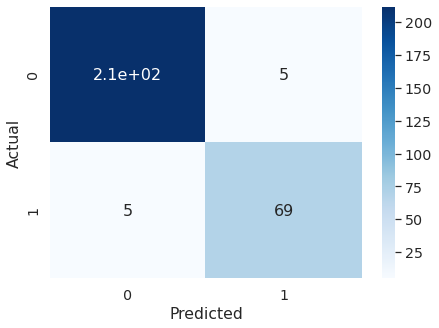

In [76]:
### Plot confusion matrix heat map

data = metrics.confusion_matrix(y_test, [int(round(i)) for i in avg_preds]) # Need to round each probability to get class
df_cm = pd.DataFrame(data, columns = [0,1], index = [0,1])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.3)
sn.heatmap(df_cm, cmap = "Blues", annot = True, annot_kws = {"size": 16})

Looks like the ensemble only misclassified 10 instances. It also misclassified the same amount under \$200,000  as over \$200,000 which is good. Clearly, class 0 is much darker because the majority of instances are under $200,000

In [53]:
print(metrics.classification_report(y_test,[int(round(i)) for i in avg_preds]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       217
           1       0.93      0.93      0.93        74

    accuracy                           0.97       291
   macro avg       0.95      0.95      0.95       291
weighted avg       0.97      0.97      0.97       291



Although we have the same number of misclassifications for each class, our f1 scores vary because of how many instances there were in each class. Our precision and recall are very high for class 0 (under \$200,000) because there were many more to classify correctly. And this is the reason our f1-score is a bit lower for class 1.

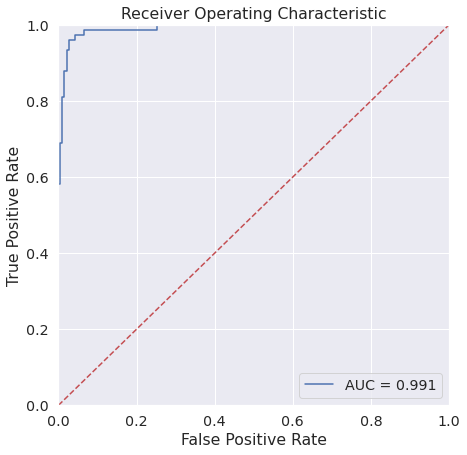

In [77]:
# Plot ROC AUC graph

fpr, tpr, threshold = metrics.roc_curve(y_test, avg_preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve is near perfect, with only a tiny bit of area not being captured. 

The XGBoost model also shows how important each feature was in it's decisions, so I'll finish off by looking at that.

In [55]:
features_ranked_df = pd.DataFrame(data={'feature': x_train_scaled.columns, 
                                        'importance': model_1.feature_importances_}
                                  ).sort_values(by='importance', ascending = False)

In [56]:
features_ranked_df[:10]

,feature,importance
24,ExterQual,0.201873
14,OverallQual,0.193594
50,KitchenQual,0.092963
43,GrLivArea,0.050068
9,Neighborhood,0.046607
35,TotalBsmtSF,0.041104
54,GarageType,0.025352
31,BsmtFinSF1,0.024452
21,Exterior2nd,0.024199
22,MasVnrType,0.021968


These results are a bit interesting. I expected OverallQual to be number one since it was so highly correlated to SalePrice. Furthermore, the top 3 are all Quality type features, and together hold about 50% of the overall importance. It turns out the categorical columns were very important as well!

The models all ended up performing very well. After all, it is not too complicated of a task, especially with how many features there are. The model's performance can be verified further by testing it on more data - there were only 74 houses over $200,000 in the test data. 

It could also be improved in several different ways. First and foremost is training with more data. Another idea would be to train more models. There are several that weren't mentioned that could be added to the ensemble. I also did not attempt to optimize each models' hyperparameters. Implementing grid search or random search would help each model perform better. I also didn't play around with the features much. The models might perform better with some features deleted or created. Lastly, performing other ensemble techniques like bagging and boosting would certainly help classify those last few intances correctly.

Overall, I am happy with the results I achieved and I now have a model which can very accurately classify higher selling houses from lower selling houses. I also now know what contributes most to these classifications.